In [45]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import *
from tensorflow.keras.datasets import mnist
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf

In [2]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()

11493376/11490434 [==============================] - 0s 0us/step


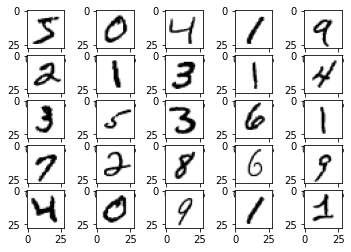

In [3]:
for i in range(25):
  plt.subplot(5,5,1+i)
  plt.imshow(x_train[i], cmap='gray_r')
plt.show()

Refresher regarding the weights of a CNN

https://datascience.stackexchange.com/questions/18341/how-are-weights-represented-in-a-convolution-neural-network

In [4]:
#Build the model that will classify an image as real or fake

def descriminator_model(input_shape=(28,28,1)):
  model = Sequential([
                      #In Conv2D, the weights are basically the elements on the filter (which the image is mutiplied by during the convolution operation)
                      Conv2D(64, (3,3), strides=(2,2),padding='same', input_shape=input_shape),
                      LeakyReLU(alpha=0.2),
                      Dropout(0.4),
                      Conv2D(64, (3,3), strides=(2,2), padding='same'),
                      LeakyReLU(alpha=0.2),
                      Dropout(0.4),
                      Flatten(),
                      Dense(1, activation='sigmoid')
  ])

  opt = Adam(lr=0.0002, beta_1=0.5)
  model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['acc'])
  return model

In [5]:
#Load and preprocess the x_train dataset. Use these examples for the discriminator to learn to differentiate from real and fake samples
def load_real():
  #Expand it to 3D by adding color channel (1 since its grayscale)
  x = np.expand_dims(x_train, axis=-1)
  x = (x/255.).astype('float32')
  return x

In [6]:
#Sample from the x_train dataset and create the x and y dataset for the real images
def generate_real(dataset, n_samples):
  #Specify the (lowest, highest, number of samples)
  #idx will be a list of n_samples indexes from 0 to 60000
  idx = np.random.randint(0, dataset.shape[0], n_samples)
  #You can index multiple examples at once by doing x[ [examples] ]
  x = dataset[idx]
  #All real images will have label of 1
  y = np.ones((n_samples, 1))

  return x, y

In [7]:
#Can kinda treat it as a reverse Conv2D, as you generate the feature maps first then use them to create the image 
#This will take a 100 element vector of random numbers(as specified in the latent dim) and generate a 2D 28x28 image
def generator_model(latent_dim):
  #You want multiple feature maps (interpretations) of our single image
  #You want 7x7 feature maps (or images) and 128 of them (So that multiple features can be learnt and subsequently collapsed to form the image)
  #You want enough nodes to create the 128 feature maps
  n_nodes = 128*7*7
  model = Sequential([
                      #Will sample from the latent space (Set of possible pixel values from gaussian-distribution) and provide them to generator model.
                      #Generator model will assign meaning to the latent points
                      Dense(n_nodes, input_dim=latent_dim),
                      LeakyReLU(alpha=0.2),
                      #Reshape into 128 different 7x7 feature maps (Reshape it into something image-like so you can pass it to the Conv2D)
                      Reshape((7,7,128)),
                      #Upsample to 14x14. Stride of (2,2) will double the width and height dimensions
                      Conv2DTranspose(128, kernel_size=(4,4), strides=(2,2), padding='same'),
                      LeakyReLU(alpha=0.2),
                      #Upsample to 28x28
                      Conv2DTranspose(128, (4,4), strides=(2,2), padding='same'),
                      LeakyReLU(alpha=0.2),
                      #Combine all the 128 feature maps into a single feature map (which will be the image)
                      Conv2D(1, (7,7), activation='sigmoid', padding='same')

  ])

  return model

In [8]:
def generate_latent(latent_dim, n_samples):
  #Generate the latent space that your generative model will sample from
  x_input = np.random.randn(latent_dim * n_samples)
  x_input = x_input.reshape(n_samples, latent_dim)
  return np.array(x_input)

In [9]:
def generate_fake(g_model, latent_dim, n_samples):
  #Generate the points in the latent space (Where the initial pixels will be sampled from)
  x_input = generate_latent(latent_dim, n_samples)
  #Generate the output image using the generative model
  pred = g_model.predict(x_input)
  #Labels for the fake generated images are 0
  y = np.zeros((n_samples, 1))

  return pred, y

In [10]:
def train_discriminator(model, dataset, n_iter=100, n_batch=256):
  #Half will be real and the other half is fake
  half_batch = int(n_batch/2)
  for i in range(n_iter):
    x_real, y_real = generate_real(dataset, half_batch)
    #Update the discriminator on the real samples
    _, real_acc = model.train_on_batch(x_real, y_real)
    

    x_fake, y_fake = generate_fake(half_batch)
    #Update the discriminator on the fake samples
    _, fake_acc = model.train_on_batch(x_fake, y_fake)

    print(f'>{i+1} real={real_acc*100}% fake={fake_acc*100}%')

In [12]:
latent_dim = 100
model = generator_model(latent_dim)
n_samples = 25
model.summary()
X, _ = generate_fake(model, latent_dim, n_samples)

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 6272)              633472    
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 6272)              0         
_________________________________________________________________
reshape (Reshape)            (None, 7, 7, 128)         0         
_________________________________________________________________
conv2d_transpose (Conv2DTran (None, 14, 14, 128)       262272    
_________________________________________________________________
leaky_re_lu_3 (LeakyReLU)    (None, 14, 14, 128)       0         
_________________________________________________________________
conv2d_transpose_1 (Conv2DTr (None, 28, 28, 128)       262272    
_________________________________________________________________
leaky_re_lu_4 (LeakyReLU)    (None, 28, 28, 128)      

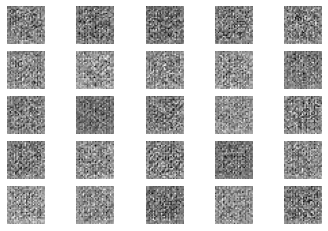

In [13]:
for i in range(n_samples):
  plt.subplot(5,5,i+1)
  plt.axis('off')
  plt.imshow(X[i,:,:,0], cmap='gray_r')

plt.show()

In [14]:
#Define the GAN model. You can still train the d_model as a standalone, but it will not be trained when training the GAN model
#The GAN will first generate a set of images (g_model) which will then be passed to the d_model for classification
#Initially, there will be a huge error during classification as the d_model will classify the generated images as 0 but the labels for these generated images are 1
#Hence, the g_model weights will be updated to make the generated image more like a 1 so for subsequent times, d_model will classify the generated image as a 1 

def GAN_model(g_model, d_model):
  #Make the weights of the discriminator model not trainable (So it will not be overtrained on fake examples)
  d_model.trainable = False
  #Connect the models. g_model will generate the samples and d_model will distinguish between them
  #Give the labels of the generated samples as 1 (Real) instead of 0 (Fake) because you want the model to see the error 
  #(Since a generated model is wrongly classified as Real) and subsequently perform gradient update such that the generated example actually becomes real (classified as real with a high probability)
  #Only the weights of the generative model will be updated during GAN model training
  model = Sequential([g_model, d_model])
  opt = Adam(lr=0.0002, beta_1=0.5)
  #The loss of the GAN model will be the loss of the d_model (The classification task)
  model.compile(loss='binary_crossentropy', optimizer=opt)
  return model

In [15]:
latent_dim = 100
d_model = descriminator_model()
g_model = generator_model(latent_dim)
gan_model = GAN_model(g_model, d_model)
gan_model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential_3 (Sequential)    (None, 28, 28, 1)         1164289   
_________________________________________________________________
sequential_2 (Sequential)    (None, 1)                 40705     
Total params: 1,204,994
Trainable params: 1,164,289
Non-trainable params: 40,705
_________________________________________________________________


In [33]:
#For every iteration (for every single batch) you want to:
#Train the discriminative model on newly generated samples (Real ones from mnist) (Fake ones from the g_model which will look more real as g_model is trained)
#And subsequently train the generative model using a randomly generated latent space 

#You train the discriminative model on correct samples (Correctly classified 1s and 0s)
#You train the generative model on 'wrong' samples (Fake samples with label of 1). These samples will eventually become 'real' (As they are more realistic) and will hence be given the correct labels (1)

#The descriminator is trained to detect generated images as 0
#The generator is trained to generate images that are detected as 1 (by the descriminator)

#Essentially, the d_model loss is used twice. Once to train the d_model to detect generated images as 0 and the other to train the g_model (through the GAN) to output generated images with label 1

def train(g_model, d_model, gan_model, dataset, latent_dim, n_epochs=100, n_batch=256):
  #Get the number of batches to go through per epoch. dataset.shape[0] is the total number of examples in the dataset
  batch_per_epoch = int(dataset.shape[0]/ n_batch)
  #n_batch is the number of samples in 1 batch
  half_batch = int(n_batch/2)
  #Loop through every epoch
  for i in range(n_epochs):
    #For every batch in the epoch, you want to generate new samples for the discriminative model and the generative model to train on
    for j in range(batch_per_epoch):
      #Generate the data for the real and fake samples
      #Get the real data from the mnist dataset
      x_real, y_real = generate_real(dataset, half_batch)
      #Generate fake images from the generative model
      #As the GAN is trained and the g_model gets better due to GAN training, the generated 'fake' images will look more 'real'. This means that technically the generated images (x_fake) should be given labels=1 instead of 0 (As the generated images look more real)
      #However, we don't do so as we want the discriminator to continue to detect the realistic generated images as 'fake'. 
      #Its called adversial as you want the discriminative model to be unable to detect the generated image as 0 (fake) but to detect it as a 1 (real) instead, DESPITE DESCRIMINATOR BEING TRAINED TO CLASSIFY GENERATED IMAGES AS 0
      #When this happens, it means that the generated images looks the same as the mnist images and hence cannot be differentiated by the discriminator
      x_fake, y_fake = generate_fake(g_model, latent_dim, half_batch)

      #Combine the real and fake images by vertically stacking them
      x = np.vstack((x_real, x_fake))
      y = np.vstack((y_real, y_fake))

      #Train the discriminator model based on the generative model generated data (fake) and the mnist dataset (real)
      #d_loss will be how well it performs on both real and generated images. 
      #d_loss will increase overtime as it classifies the generated images (which become more realistic overtime) as 1 instead of a 0
      d_loss, _ = d_model.train_on_batch(x,y)

      #Prepare the data to be fed into the GAN model
      #Generate points in latent space for training the GAN model (To be fed as input to the generative model which is the first layer in the GAN)
      x_gan = generate_latent(latent_dim, n_batch)
      #Treat the generated images as 1 (Real) so backpropagation will update the generative model weights to make the generated images look more like a 1 
      #You want to train the generative model until it generates images that have a high probability of label being 1 (Looks realistic)
      y_gan = np.ones((n_batch, 1))

      #Update the generator weights based on the discriminator's error. As you froze the discriminator weights, the discriminator is not updated
      #g_loss will be lower overtime as the g_model generates images which look more real, and is hence correctly classified by the d_model as 1
      g_loss = gan_model.train_on_batch(x_gan, y_gan)
      
      print(f'Epoch {i+1}/{n_epochs}  Batch {j+1}/{batch_per_epoch}  Discriminative Loss: {d_loss}  Generative Loss: {g_loss}')

    if (i+1) % 10 == 0:
      g_performance(i, g_model, d_model, dataset, latent_dim)

In [34]:
def g_performance(epoch, g_model, d_model, dataset, latent_dim, n_samples=150):
  x_real, y_real = generate_real(dataset, n_samples)
  _, acc_real = d_model.evaluate(x_real, y_real, verbose=0)
  x_fake, y_fake = generate_fake(g_model, latent_dim, n_samples)

  #As the g_model gets better, acc_real will go down as real images (which are supposed to have label 1) are classified as 0 instead (Because its unable to differentiate between real and generated images)
  _, acc_fake = d_model.evaluate(x_fake, y_fake, verbose=0)
  print(f'>Accuracy Real: {acc_real*100}  >Accuracy Fake:{acc_fake*100}')

  #save the generated images  (subplot)
  save_plot(x_fake, epoch)
  filename = f'generator_model_{epoch+1}.h5'
  #Save the generator model weights (Not the whole GAN model weights!)
  g_model.save(filename)

In [35]:
def save_plot(examples, epoch, n=7):
  examples = (examples + 1) / 2.0
  # plot images
  for i in range(n*n):
    plt.subplot(n,n,i+1)
    plt.axis('off')
    plt.imshow(np.squeeze(examples[i]), cmap='gray_r')
  
  filename = f'generated_plot_e{epoch+1}.png'
  plt.savefig(filename)
  plt.close()

In [37]:
latent_dim = 100
d_model = descriminator_model()
g_model = generator_model(latent_dim)
gan_model = GAN_model(g_model, d_model)
dataset = load_real()

train(g_model, d_model, gan_model, dataset, latent_dim,n_epochs=100)

Streaming output truncated to the last 5000 lines.
Epoch 79/100  Batch 153/234  Discriminative Loss: 0.6862170696258545  Generative Loss: 0.7117383480072021
Epoch 79/100  Batch 154/234  Discriminative Loss: 0.6943554878234863  Generative Loss: 0.7063131928443909
Epoch 79/100  Batch 155/234  Discriminative Loss: 0.6880928874015808  Generative Loss: 0.7110324501991272
Epoch 79/100  Batch 156/234  Discriminative Loss: 0.6866553425788879  Generative Loss: 0.7363771200180054
Epoch 79/100  Batch 157/234  Discriminative Loss: 0.6923002004623413  Generative Loss: 0.7169846296310425
Epoch 79/100  Batch 158/234  Discriminative Loss: 0.6916484236717224  Generative Loss: 0.687171995639801
Epoch 79/100  Batch 159/234  Discriminative Loss: 0.6899803876876831  Generative Loss: 0.6873167753219604
Epoch 79/100  Batch 160/234  Discriminative Loss: 0.6899306774139404  Generative Loss: 0.7015460133552551
Epoch 79/100  Batch 161/234  Discriminative Loss: 0.68773353099823  Generative Loss: 0.695997238159179

In [39]:
def show_synthetic(examples, n):
  for i in range(n*n):
    plt.subplot(n,n,i+1)
    plt.axis('off')
    plt.imshow(np.squeeze(examples[i]), cmap='gray_r')
  plt.show()

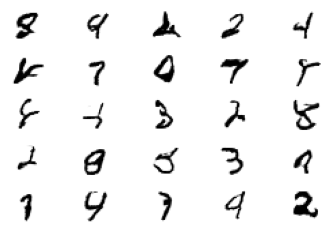

In [55]:
#Generates 25 images by default
def synthetic(n_samples=25):
  #If you didn't train your model but want to use pretrained h5 models instead
  model = tf.keras.models.load_model('/content/generator_model_100.h5')
  latent_points = generate_latent(latent_dim, n_samples)
  gen = model.predict(latent_points)
  show_synthetic(gen, 5)

synthetic()

Generated images and .h5 weights can be found here:

https://www.dropbox.com/sh/f5mn9elmlxeuc3e/AADwB-oKWMIfvMtOYOWEUKFLa?dl=0